In [620]:
#!pip install gymnasium

In [621]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Create UAV environment.

In [ ]:
class UAV_Env():
    def __init__(self, Users=500, size=2000, UAV=1, v_UAV=50,
                 UAV_coverage=400, max_steps=50, N_t=3):
        self.Users = Users
        self.size = size
        self.UAV = UAV
        self.UAV_coverage = UAV_coverage
        self.max_steps = max_steps
        self.v_UAV = v_UAV
        self.N_t = N_t

        self.uav_location = np.zeros((2, self.UAV))
        self.users_location = np.random.normal(loc=self.size/2, scale=self.size/6, size=(2, self.Users))
        self.UAV_behavior = np.zeros((2, self.max_steps))
        self.step_ = 0  # step counter
        self.action_history = []  # store action history

        self.observation_space = gym.spaces.Box(0, self.size, shape=(2, self.UAV), dtype=float)
        self.action_space = gym.spaces.Discrete(5)
        self._action_to_direction = {
            0: np.array([0, 0]),         # stay
            1: np.array([0, self.v_UAV]),    # up
            2: np.array([-self.v_UAV, 0]),   # left
            3: np.array([0, -self.v_UAV]),   # down
            4: np.array([self.v_UAV, 0])     # right
        }

    def step(self, action):
        self.action_history.append(action)  # save the action

        # update UAV location
        tem = self.uav_location[:, 0] + self._action_to_direction[action]
        if 0 <= tem[0] <= self.size and 0 <= tem[1] <= self.size:
            self.uav_location[:, 0] = tem

        # compute number of users in coverage
        d_distance = np.linalg.norm(self.users_location - self.uav_location[:, 0].reshape(2, 1), axis=0)
        connected_users = (d_distance <= self.UAV_coverage).astype(int)
        total_connect = np.sum(connected_users)

        # compute reward
        if total_connect < self.N_t:
            reward = -1
        elif total_connect == self.N_t:
            reward = 0
        else:
            reward = total_connect - self.N_t
            self.N_t += 5

        self.step_ += 1

        # penalize early stationary behavior
        if self.step_ <= 20 and action == 0:
            reward -= 5

        # penalize if the same action is repeated 4 times in a row
        if len(self.action_history) >= 4 and len(set(self.action_history[-4:])) == 1:
            reward -= 100  # heavy penalty

        done = self.step_ >= self.max_steps
        next_state = self.uav_location.copy()

        return next_state, reward, done

    def reset(self):
        self.uav_location = np.zeros((2, self.UAV))
        self.UAV_behavior = np.zeros((2, self.max_steps))
        self.step_ = 0
        self.N_t = 2
        self.action_history = []  # reset action history
        return self.uav_location.copy()


In [624]:
env = UAV_Env()

In [625]:
state_space = env.observation_space.shape[0]
print('State Space:', state_space)
action_space = env.action_space.n
print('Action Space:', action_space)

State Space: 2
Action Space: 5


Create Neuron Network

In [626]:
class Deep_Q(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Deep_Q, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

Paramenter to train

In [ ]:
learning_rate = 0.0001
gamma = 0.99
epsilon = 1
batch_size = 64
target_update_freq = 100
memory_size = 50000
episodes = 15000#1500

Create 2 NN: policy_net and target_net

In [628]:
policy_net1 = Deep_Q(state_space, action_space)
target_net = Deep_Q(state_space, action_space)

optimizer = optim.Adam(policy_net1.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

Use epsilon to select a random action.

In [ ]:
def select_action(state, epsilon):
    rand_value = random.random()
    if rand_value < epsilon:
        return env.action_space.sample()  # Explore
    else:
        state = torch.FloatTensor(state).squeeze()
        
        q_values = policy_net1(state)
        return torch.argmax(q_values).item()  # Exploit: choose the optimal action

def decay_epsilon(epsilon):
    min_epsilon = 0.0001
    annealing_rate = 0.9997  # decay rate of epsilon
    epsilon = min_epsilon + annealing_rate * (epsilon - min_epsilon)
    return epsilon


Cteate function to train model

In [ ]:
def optimize_model():
    if len(memory) < batch_size:  # If memory < batch_size, exit early
        return

    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
    # Randomly sample a batch and unpack into separate components

    state_batch = torch.FloatTensor(np.array(state_batch))
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(np.array(next_state_batch))
    done_batch = torch.FloatTensor(done_batch)
    # Convert data into Float Tensors

    # Compute q_values for current states, only for the selected actions
    state_batch = state_batch.squeeze(-1)
    q_values = policy_net1(state_batch).gather(1, action_batch).squeeze()

    next_state_batch = next_state_batch.squeeze(-1)
    # Compute target Q-values based on next states
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]  # Choose max for training
        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)

    # Use Bellman equation to compute the loss
    loss = nn.MSELoss()(q_values, target_q_values)

    # Update policy network; target network is not updated here
    optimizer.zero_grad()
    loss.backward()  # Compute gradients of the network parameters w.r.t. current loss
    optimizer.step()  # Apply the gradient update to policy_net1


Train and save model.

In [631]:
best_reward = float('-inf')
rewards_per_episode = []
steps_done = 0

for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        if isinstance(state, tuple):
            state = state[0]

        action = select_action(state, epsilon)
        
        next_state, reward, done= env.step(action)
        #print(action,reward)

        memory.append((state, action, reward, next_state, done))
        state = next_state
        episode_reward += reward

        # for s in memory:
            #print(s[0])
            # print(np.array(s[0]).shape)    # in ra shape state

        optimize_model()

        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net1.state_dict())

        steps_done += 1

    epsilon = decay_epsilon(epsilon)
    rewards_per_episode.append(episode_reward)
    # print(action)

    print(f'Episode {episode}: Reward = {episode_reward:.2f}, Epsilon = {epsilon:.5f}')

    if episode_reward >= best_reward:
        best_reward = episode_reward
        torch.save(policy_net1.state_dict(), 'best_policy_net_1.pth')
        print(f' Saved better model at episode {episode} with reward = {episode_reward:.2f}')


Episode 0: Reward = -165.00, Epsilon = 0.99970
 Saved better model at episode 0 with reward = -165.00
Episode 1: Reward = -70.00, Epsilon = 0.99940
 Saved better model at episode 1 with reward = -70.00
Episode 2: Reward = -139.00, Epsilon = 0.99910
Episode 3: Reward = -165.00, Epsilon = 0.99880
Episode 4: Reward = -165.00, Epsilon = 0.99850
Episode 5: Reward = -61.00, Epsilon = 0.99820
 Saved better model at episode 5 with reward = -61.00
Episode 6: Reward = -85.00, Epsilon = 0.99790
Episode 7: Reward = -73.00, Epsilon = 0.99760
Episode 8: Reward = -280.00, Epsilon = 0.99730
Episode 9: Reward = -83.00, Epsilon = 0.99700
Episode 10: Reward = -165.00, Epsilon = 0.99671
Episode 11: Reward = -68.00, Epsilon = 0.99641
Episode 12: Reward = -170.00, Epsilon = 0.99611
Episode 13: Reward = -360.00, Epsilon = 0.99581
Episode 14: Reward = -55.00, Epsilon = 0.99551
 Saved better model at episode 14 with reward = -55.00
Episode 15: Reward = -55.00, Epsilon = 0.99521
 Saved better model at episode 1

Create function to evaluate model.

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def evaluate_agent(env, policy_net, n_eval_episodes=1, max_steps=50, render=False, fixed_seed=None):
    total_rewards = []

    for ep in range(n_eval_episodes):
        state = env.reset()
        if isinstance(state, tuple):  # For new Gym API compatibility
            state = state[0]

        done = False
        ep_reward = 0
        steps = 0
        uav_path = []        # Save UAV path
        action_save = []     # Save chosen actions

        while not done and steps < max_steps:
            # Select greedy action
            state_tensor = torch.FloatTensor(state.T).unsqueeze(0)
            with torch.no_grad():
                q_values = policy_net(state_tensor)
                action = torch.argmax(q_values).item()
                action_save.append(action)

            next_state, reward, done = env.step(action)
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            # Record UAV position
            uav_pos = env.uav_location[:, 0]
            uav_path.append(uav_pos.copy())

            # Update for next step
            state = next_state
            ep_reward += reward
            steps += 1

        total_rewards.append(ep_reward)
        print(f"\n>>> Evaluation Episode {ep+1}: Total Reward = {ep_reward}")

        # After episode ends: plot UAV full trajectory
        uav_path = np.array(uav_path).T  # shape (2, T)
        users = env.users_location

        # Coverage region at final position
        distances = np.linalg.norm(users - uav_path[:, -1].reshape(2, 1), axis=0)
        covered_idx = distances <= env.UAV_coverage
        covered_users = users[:, covered_idx]

        # --- Plot map ---
        plt.figure(figsize=(8, 8))
        plt.scatter(users[0], users[1], color='lightgray', label='All Users', s=10)
        if covered_users.shape[1] > 0:
            plt.scatter(covered_users[0], covered_users[1], color='blue', label='Covered Users', s=20)

        # Plot UAV path
        plt.plot(uav_path[0], uav_path[1], color='green', linewidth=2, label='UAV Path')
        # plt.scatter(uav_path[0][0], uav_path[1][0], color='orange', s=100, marker='o', label='Start')
        plt.scatter(uav_path[0][-1], uav_path[1][-1], color='red', s=100, marker='^', label='End (UAV)')

        # Plot UAV coverage area at the final position
        circle = plt.Circle((uav_path[0, -1], uav_path[1, -1]), env.UAV_coverage,
                            color='red', alpha=0.2, label='UAV Coverage')
        plt.gca().add_patch(circle)

        plt.title(f"UAV Path in Evaluation Episode {ep+1}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.xlim(0, env.size)
        plt.ylim(0, env.size)
        plt.legend()
        plt.grid(True)
        plt.text(0, env.size - 50, f"Covered Users: {int(np.sum(covered_idx))}", fontsize=12)
        plt.tight_layout()
        plt.show()

    mean_reward = sum(total_rewards) / n_eval_episodes
    std_reward = (sum((r - mean_reward) ** 2 for r in total_rewards) / n_eval_episodes) ** 0.5
    print(f"\n=== Final Result ===")
    print(f"Mean Reward over {n_eval_episodes} episodes: {mean_reward:.2f} ± {std_reward:.2f}")

    return mean_reward, std_reward, total_rewards, action_save



>>> Evaluation Episode 1: Total Reward = 3161


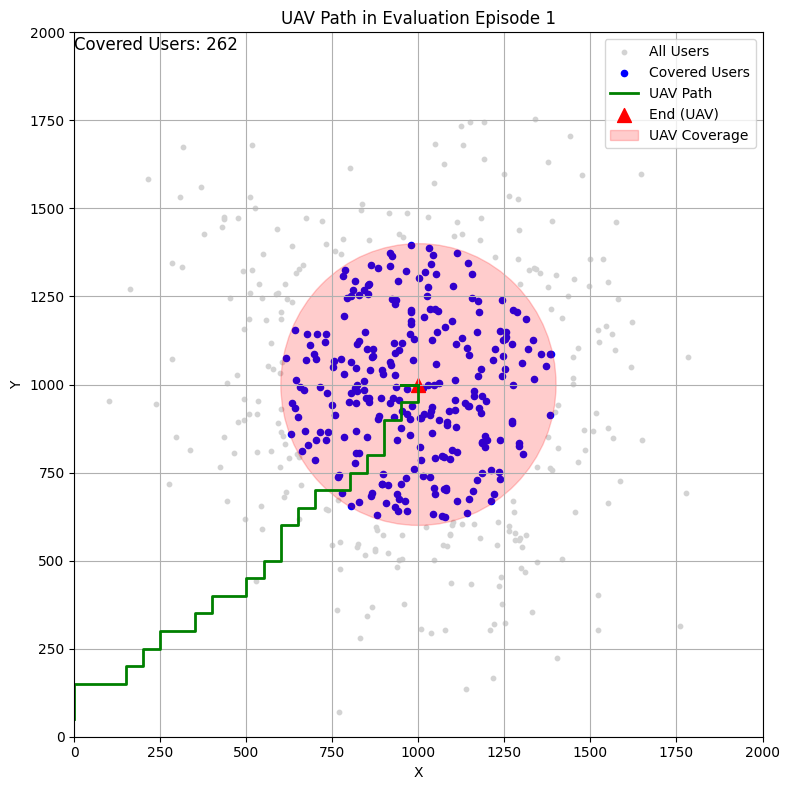


=== Final Result ===
Mean Reward over 1 episodes: 3161.00 ± 0.00
[1, 1, 1, 4, 4, 4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 1, 1, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 1, 1, 4, 1, 4, 1, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4]


In [633]:
policy_net1.load_state_dict(torch.load('best_policy_net_1.pth'))
policy_net1.eval()

mean, std, total_rewards,action_space = evaluate_agent(env, policy_net1, n_eval_episodes=1, max_steps=50)
print(action_space)